<a href="https://colab.research.google.com/github/eispoohw/CS493-Math-Methods-in-ML/blob/main/lab7_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 # FashionMNIST

 ## Задание 7.2

<img src="https://emiliendupont.github.io/imgs/mnist-chicken/mnist-and-fashion-examples.png">

На практике построим нейронную сеть для классификации картиной. В качестве входных данных используются картинки одежды (в градациях серого, то есть цветовых каналов не 3, а 1). По входной картинке нужно предсказать тип одежды.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
from torchvision.transforms import transforms

from tqdm.notebook import tqdm

Скачаем обучающую и контрольную выборки.

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 4

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



Каждая картинка имеет класс от 0 до 9, расшифровка меток класса:  

|class_id|class_name|
|----|----|
|0| T-shirt/top|
|1| Trouser|
|2| Pullover|
|3| Dress|
|4| Coat|
|5| Sandal|
|6| Shirt|
|7| Sneaker|
|8| Bag|
|9| Ankle boot| 

<h2 style="text-align: center;"><b>Задание</b></h2>

Посмотрите на датасет.
* Сколько картинок в train? В test?
* Равномерно ли распределено количество объектов разных классов в train датасете (это можно понять, поработав с полем `train_data` у переменной `trainset`)? в test?
* Выведите несколько картинок с помощью `pyplot`

Используя материалы семинаров по многослойным  и свёрточным сетям, напишите:
1.  Многослойную нейронную сеть MLP (Multi-Layer Perceptron) классифицирующую этот датасет
2. Свёрточную сеть, классифицирующую этот датасет
3. Сравните их качество (по графикам лосса и по Accuracy Score)

Если качество, которое получается у  нейросети, выше 95%, то Вы решили задачу с точностью, которую можно использовать в жизни.

In [3]:
print(f"train: {len(trainset)} rows\ntest: {len(testset)} rows")

train: 60000 rows
test: 10000 rows


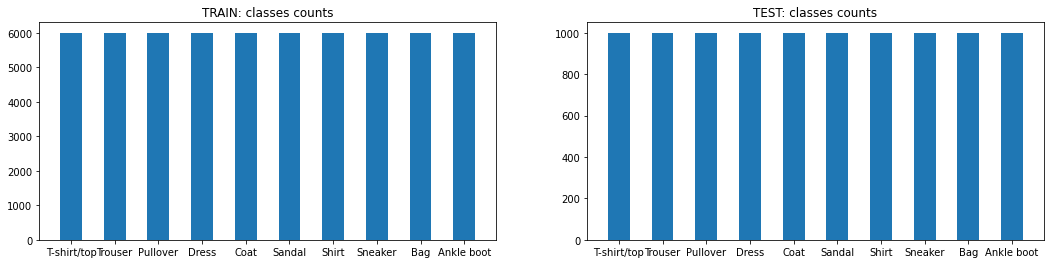

In [4]:
from collections import Counter, defaultdict

class_names, class_counts = trainset.targets.unique(return_counts=True)
class_names = [classes[int(i)] for i in class_names]

fig = plt.figure(figsize=(18, 4))

sub_test = fig.add_subplot(1, 2, 1)
sub_test.bar(class_names, class_counts, width=0.5)
sub_test.set_title('TRAIN: classes counts')

class_names, class_counts = testset.targets.unique(return_counts=True)
class_names = [classes[int(i)] for i in class_names]

sub_train = fig.add_subplot(1, 2, 2)
sub_train.bar(class_names, class_counts, width=0.5)
sub_train.set_title('TEST: classes counts')
plt.show()

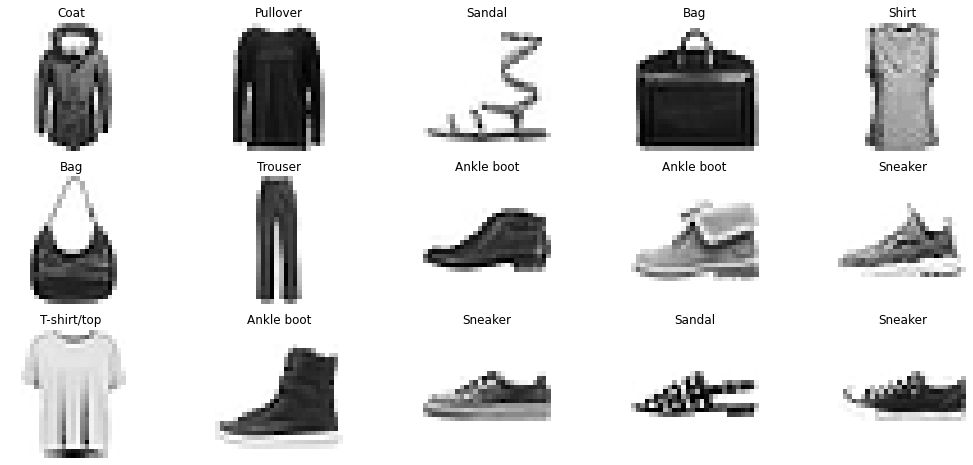

In [5]:
figure = plt.figure(figsize=(18, 8))
cols, rows = 5, 3

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(trainset), size=(1,)).item()
    img, label = trainset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(classes[label])
    plt.axis("off")
    plt.imshow((1-img[0]), cmap="gray")

plt.show()

## MLP

In [6]:
import torch.nn.functional as F

class MLPNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = torch.nn.Linear(28 * 28, 200)
        self.fc2 = torch.nn.Linear(200, 50)
        self.fc3 = torch.nn.Linear(50, 10)

    def forward(self, x):
        x = F.elu(self.fc1(x))
        x = F.elu(self.fc2(x))
        x = self.fc3(x)
        return x

net = MLPNet().to(device)

In [7]:
num_epochs = 3
epochs = tqdm(range(num_epochs))

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.001)

losses_MLP = []

for epoch in epochs:  
    running_loss = 0.0
    for i, batch in enumerate(tqdm(trainloader)):
        x, y = batch
        x = x.view(-1, 28 * 28).to(device)
        y_pred = net(x.to(device))
        loss = criterion(y_pred, y.to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 500 == 499: 
            losses_MLP.append(running_loss / 500)
            running_loss = 0.0

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

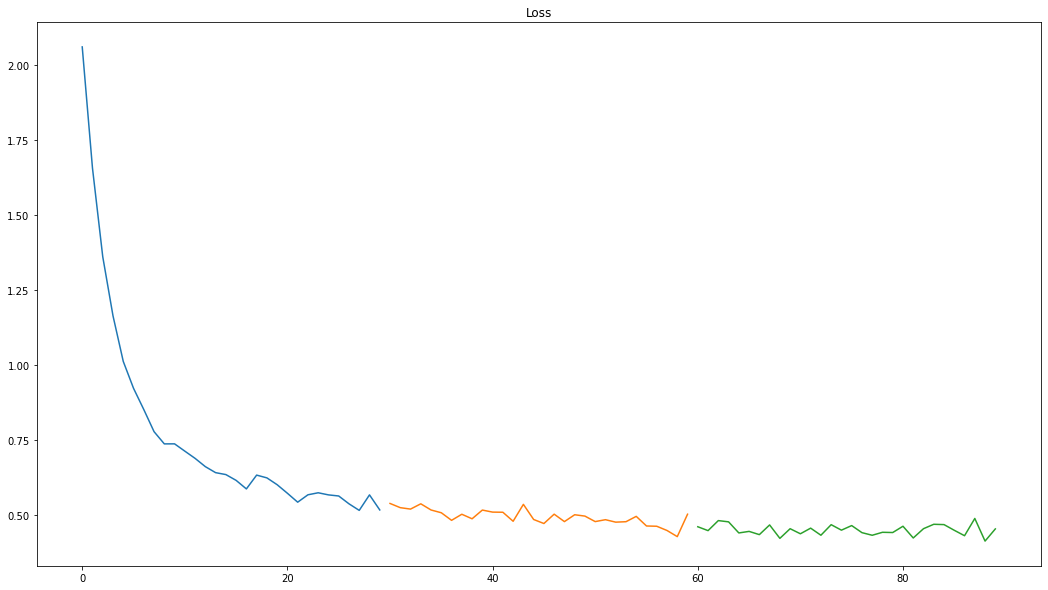

In [8]:
fig = plt.figure(figsize=(18, 10))
step = len(losses_MLP) // num_epochs

for i in range(num_epochs):
    plt.plot(np.arange(i*step, (i+1)*step), losses_MLP[i*step:(i+1)*step])

plt.title('Loss')
plt.show()

In [10]:
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images.view(-1, 28 * 28).to(device))
        _, predictions = torch.max(outputs, 1)
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

print(f'Accuracy of the network on the 10000 test images: {100 * sum(correct_pred.values()) / sum(total_pred.values()) } %\n')

for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy of the network on the 10000 test images: 83.2 %

Accuracy for class: T-shirt/top is 85.1 %
Accuracy for class: Trouser is 95.7 %
Accuracy for class: Pullover is 74.3 %
Accuracy for class: Dress is 85.4 %
Accuracy for class: Coat  is 76.2 %
Accuracy for class: Sandal is 91.5 %
Accuracy for class: Shirt is 48.4 %
Accuracy for class: Sneaker is 91.2 %
Accuracy for class: Bag   is 93.5 %
Accuracy for class: Ankle boot is 90.7 %


## Сверточная сеть

`INPUT -> [[CONV -> RELU]*N -> POOL?]*M -> [FC -> RELU]*L -> FC` 

In [54]:
class NetC(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = torch.nn.Linear(64 * 6 * 6, 512)
        self.fc2 = torch.nn.Linear(512, 128)
        self.fc3 = torch.nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 6 * 6)  
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [55]:
num_epochs = 4
epochs = tqdm(range(num_epochs))

netC = NetC().to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(netC.parameters(), lr=0.001)

losses = []

for epoch in epochs:  
    running_loss = 0.0
    for i, batch in enumerate(tqdm(trainloader)):
        x, y = batch
        y_pred = netC(x.to(device))
        loss = criterion(y_pred, y.to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 500 == 499: 
            losses.append(running_loss / 500)
            running_loss = 0.0

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

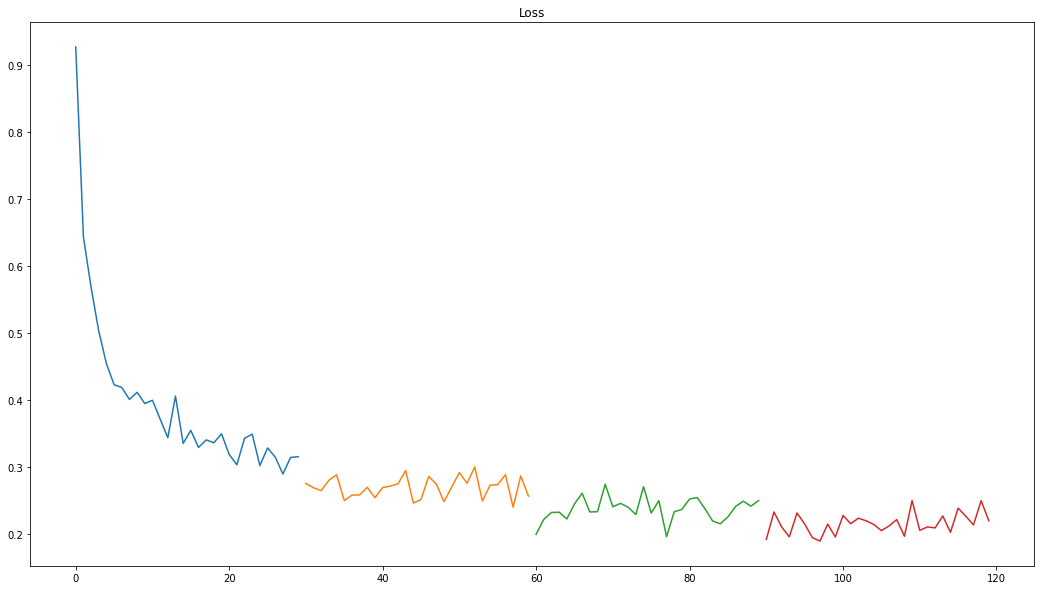

In [58]:
fig = plt.figure(figsize=(18, 10))
step = len(losses) // num_epochs

for i in range(num_epochs):
    plt.plot(np.arange(i*step, (i+1)*step), losses[i*step:(i+1)*step])

plt.title('Loss')
plt.show()

In [59]:
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = netC(images.to(device))
        _, predictions = torch.max(outputs, 1)
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

print(f'Accuracy of the network on the 10000 test images: {100 * sum(correct_pred.values()) / sum(total_pred.values()) } %\n')

for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy of the network on the 10000 test images: 90.71 %

Accuracy for class: T-shirt/top is 84.9 %
Accuracy for class: Trouser is 98.0 %
Accuracy for class: Pullover is 90.5 %
Accuracy for class: Dress is 92.5 %
Accuracy for class: Coat  is 82.7 %
Accuracy for class: Sandal is 97.5 %
Accuracy for class: Shirt is 70.5 %
Accuracy for class: Sneaker is 96.6 %
Accuracy for class: Bag   is 96.7 %
Accuracy for class: Ankle boot is 97.2 %


Параметры и архитектура подбирались исходя из результатов графиков и значений accuracy, а также с обращением к источникам.

### Источники:
- https://colab.research.google.com/drive/1f4XVs5iBoxnuqvk_PCFu4e7-xRuz-u-c#scrollTo=P-z3MZ2scbG3
- https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
- https://github.com/zalandoresearch/fashion-mnist
- https://www.kaggle.com/code/rutvikdeshpande/fashion-mnist-cnn-beginner-98/notebook 
- https://youtu.be/OMDn66kM9Qc 